# Experimento 3: _One Vs All_ com `SVM`

Realizando classificação com SVM usando para treino os arquivos `chbNN_com_dwt.csv` onde `NN` pertence ao `file_range`, com exceção do que será usado para teste.

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd

from seaborn import heatmap
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Carregando intervalo de chb
file_range = [
    '01', '02', '03', '04', '05', '07', '08',
    '10', '11', '12', '13', '14', '15', '16',
    '17', '18', '19', '21', '22', '23', '24'
]

def dataframe_from_chb(chb_number:str):
    df = pd.read_csv(f'./chb{chb_number}/chb{chb_number}_com_dwt.csv')
    df['chb'] = chb_number
    return df

chb_df = pd.concat([dataframe_from_chb(file) for file in file_range], ignore_index=True)


some_6_channels = ['2', '3', '6', '7', '10', '14']
some_8_channels = some_6_channels + ['5', '11']

# Filtrando colunas do chb que são referentes aos canais em some_6_channels
columns_from_6_channels = [column for column in chb_df.columns if column.split('-')[-1] in some_6_channels]

# Filtrando colunas do chb que são referentes aos canais em some_8_channels
columns_from_8_channels = [column for column in chb_df.columns if column.split('-')[-1] in some_8_channels]

In [2]:
acc_df_list = []

proba_dict = {
    file:{
        channel:np.array([]) for channel in ['all', '6ch', '8ch']
    } for file in file_range
}

for file in file_range:

    # Separando dados de treino e teste
    chb_copy_df = chb_df.copy()

    chb_train = chb_copy_df.query('chb != @file')
    chb_test = chb_copy_df.query('chb == @file')

    chb_train.pop('chb')
    chb_test.pop('chb')

    y_train = chb_train.pop('target').values
    y_test = chb_test.pop('target').values

    # Para 20 rodadas com todos os canais
    sc_all = StandardScaler().fit(chb_train.values)
    X_all = sc_all.transform(chb_train.values)

    # Para 20 rodadas com os 6 canais
    sc_6ch = StandardScaler().fit(chb_train[columns_from_6_channels].values)
    X_6_channels = sc_6ch.transform(chb_train[columns_from_6_channels].values)

    # Para 20 rodadas com os 8 canais
    sc_8ch = StandardScaler().fit(chb_train[columns_from_8_channels].values)
    X_8_channels = sc_8ch.transform(chb_train[columns_from_8_channels].values)

    # Instanciando e treinando classificadores
    model_all = SVC(cache_size=500, probability=True).fit(X_all, y_train)
    model_6_ch = SVC(cache_size=500, probability=True).fit(X_6_channels, y_train)
    model_8_ch = SVC(cache_size=500, probability=True).fit(X_8_channels, y_train)

    # gerando probabilidades
    proba_all = model_all.predict_proba(chb_test.values)
    proba_6ch = model_6_ch.predict_proba(chb_test[columns_from_6_channels].values)
    proba_8ch = model_8_ch.predict_proba(chb_test[columns_from_8_channels].values)

    # Salvando probabilidades em dicionário
    for channel, proba_arr in zip(['all', '6ch', '8ch'], [proba_all, proba_6ch, proba_8ch]):
        pos_sample, neg_sample = [], []

        for proba, target in zip(proba_arr, y_test):
            pos_sample.append(proba) if target == 1 else neg_sample.append(proba)

        proba_dict[file][channel] = np.array([neg_sample, pos_sample])

    # Formando dataframe de acurácias
    acc_df = pd.DataFrame(data=[file], columns=['chb'], dtype=np.float64)
    acc_df['all channels'] = model_all.score(sc_all.transform(chb_test.values), y_test)
    acc_df['2_3_6_7_10_14 channels'] = model_6_ch.score(sc_6ch.transform(chb_test[columns_from_6_channels].values), y_test)
    acc_df['2_3_5_6_7_10_11_14 channels'] = model_8_ch.score(sc_8ch.transform(chb_test[columns_from_8_channels].values), y_test)

    acc_df_list.append(acc_df)

one_vs_all_df = pd.concat(acc_df_list, ignore_index=True).sort_values(by='chb')
one_vs_all_df.to_csv('./svc-oneVSall.csv', index=False)

## Metricas

In [3]:
one_vs_all_df = pd.read_csv('./svc-oneVSall.csv')
one_vs_all_df.style.background_gradient(cmap='Blues', subset=one_vs_all_df.columns[1:]).hide_index()

chb,all channels,2_3_6_7_10_14 channels,2_3_5_6_7_10_11_14 channels
1.000000,0.870370,0.784722,0.789352
2.000000,0.851190,0.952381,0.958333
3.000000,0.915816,0.941327,0.948980
4.000000,0.846774,0.862903,0.857527
5.000000,0.925455,0.947273,0.929091
7.000000,0.968750,0.950000,0.959375
8.000000,0.724176,0.715385,0.716484
10.000000,0.949541,0.949541,0.961009
11.000000,0.890000,0.841250,0.862500
12.000000,0.709034,0.658613,0.638655


In [4]:
one_vs_all_df.style.background_gradient(cmap='Blues', subset=one_vs_all_df.columns[1:], axis='columns').hide_index()

chb,all channels,2_3_6_7_10_14 channels,2_3_5_6_7_10_11_14 channels
1.000000,0.870370,0.784722,0.789352
2.000000,0.851190,0.952381,0.958333
3.000000,0.915816,0.941327,0.948980
4.000000,0.846774,0.862903,0.857527
5.000000,0.925455,0.947273,0.929091
7.000000,0.968750,0.950000,0.959375
8.000000,0.724176,0.715385,0.716484
10.000000,0.949541,0.949541,0.961009
11.000000,0.890000,0.841250,0.862500
12.000000,0.709034,0.658613,0.638655


## Descrição geral

,all channels,2_3_6_7_10_14 channels,2_3_5_6_7_10_11_14 channels
count,21.000000,21.000000,21.000000
mean,0.812359,0.806454,0.810642
std,0.175079,0.182006,0.185899
min,0.323529,0.352941,0.358974
25%,0.796875,0.784722,0.789352
50%,0.870370,0.868056,0.866803
75%,0.925455,0.944444,0.944444
max,0.969697,0.974747,0.979798


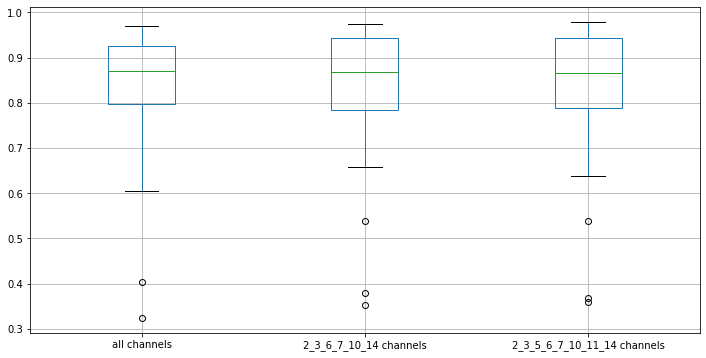

In [5]:
one_vs_all_df[one_vs_all_df.columns[1:]].boxplot(figsize=(12, 6))
one_vs_all_df[one_vs_all_df.columns[1:]].describe()

## Descrição excluindo os dois piores chb

,all channels,2_3_6_7_10_14 channels,2_3_5_6_7_10_11_14 channels
count,19.000000,19.000000,19.000000
mean,0.859588,0.852862,0.857729
std,0.095695,0.113659,0.117567
min,0.604651,0.538760,0.538760
25%,0.829637,0.823515,0.830051
50%,0.875000,0.870690,0.871528
75%,0.926495,0.945859,0.946712
max,0.969697,0.974747,0.979798


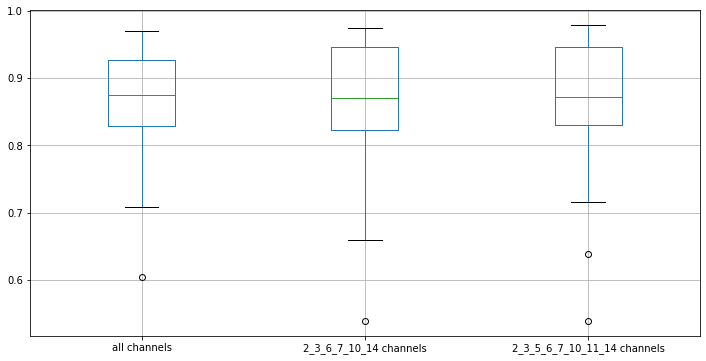

In [6]:
one_vs_all_df.sort_values(by='all channels', ascending=False).head(19)[one_vs_all_df.columns[1:]].boxplot(figsize=(12, 6))
one_vs_all_df.sort_values(by='all channels', ascending=False).head(19)[one_vs_all_df.columns[1:]].describe()

Margem de probabilidade para todos os canais do CHB 01
Para o grupo de canais all


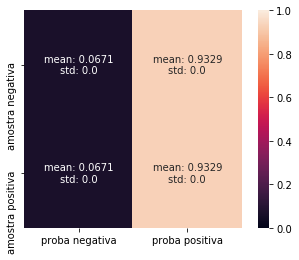

Para o grupo de canais 6ch


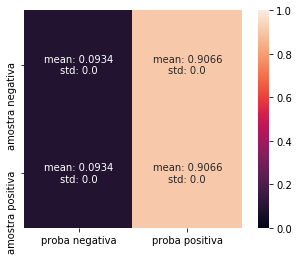

Para o grupo de canais 8ch


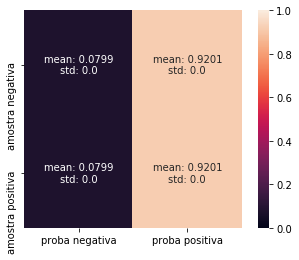

Margem de probabilidade para todos os canais do CHB 02
Para o grupo de canais all


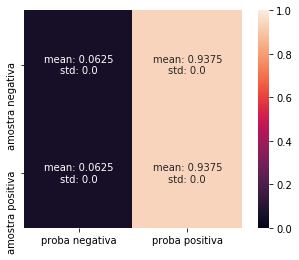

Para o grupo de canais 6ch


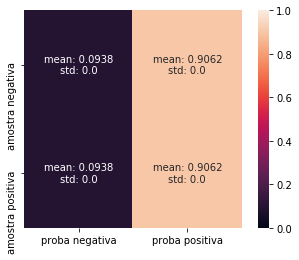

Para o grupo de canais 8ch


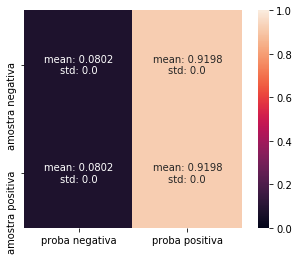

Margem de probabilidade para todos os canais do CHB 03
Para o grupo de canais all


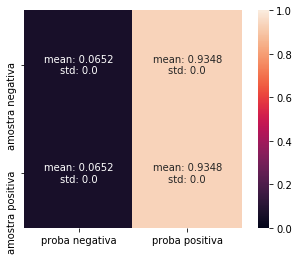

Para o grupo de canais 6ch


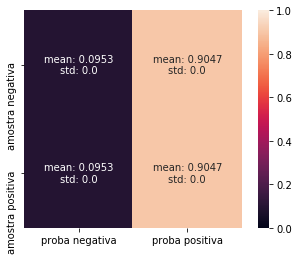

Para o grupo de canais 8ch


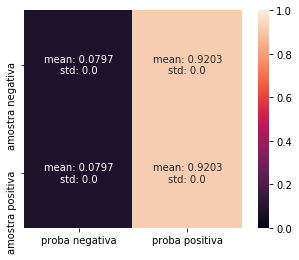

Margem de probabilidade para todos os canais do CHB 04
Para o grupo de canais all


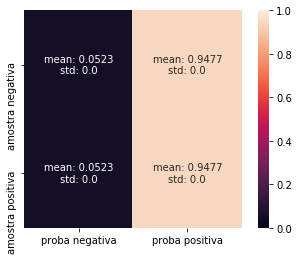

Para o grupo de canais 6ch


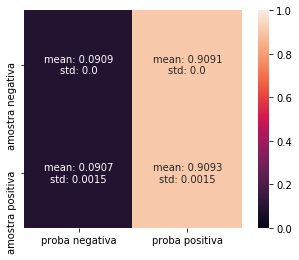

Para o grupo de canais 8ch


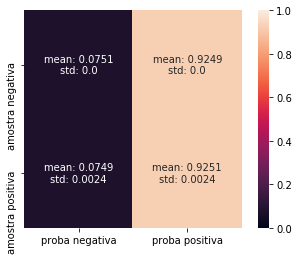

Margem de probabilidade para todos os canais do CHB 05
Para o grupo de canais all


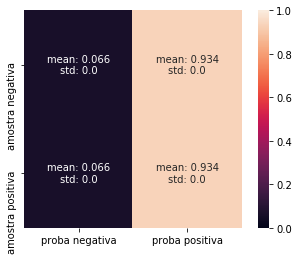

Para o grupo de canais 6ch


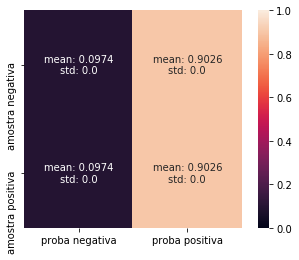

Para o grupo de canais 8ch


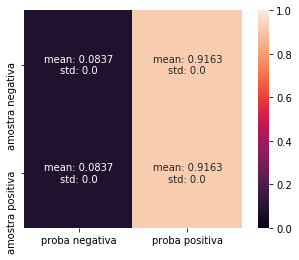

Margem de probabilidade para todos os canais do CHB 07
Para o grupo de canais all


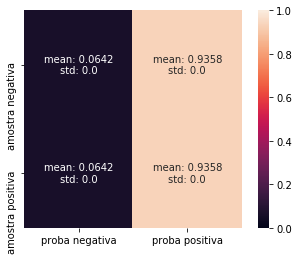

Para o grupo de canais 6ch


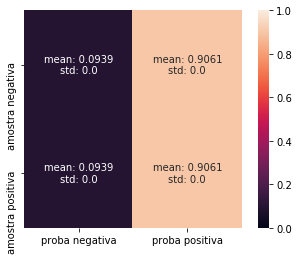

Para o grupo de canais 8ch


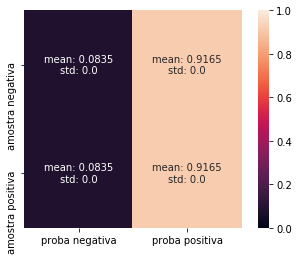

Margem de probabilidade para todos os canais do CHB 08
Para o grupo de canais all


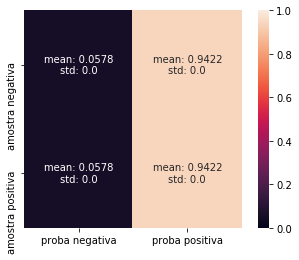

Para o grupo de canais 6ch


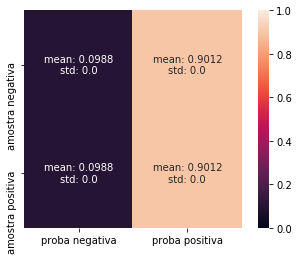

Para o grupo de canais 8ch


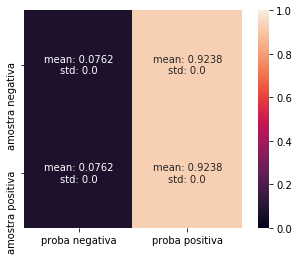

Margem de probabilidade para todos os canais do CHB 10
Para o grupo de canais all


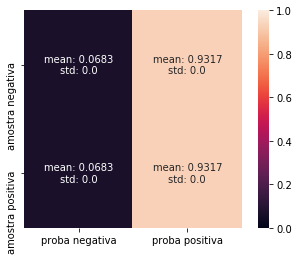

Para o grupo de canais 6ch


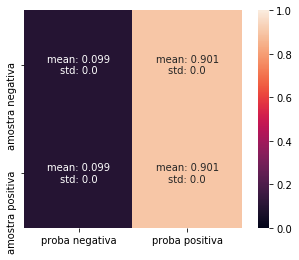

Para o grupo de canais 8ch


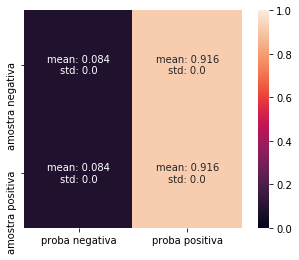

Margem de probabilidade para todos os canais do CHB 11
Para o grupo de canais all


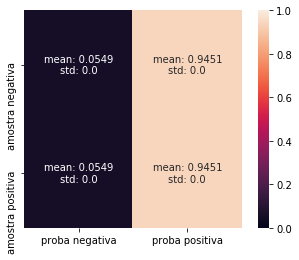

Para o grupo de canais 6ch


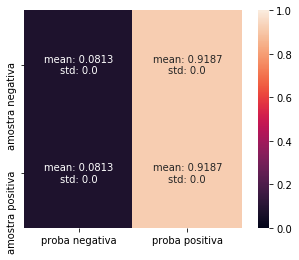

Para o grupo de canais 8ch


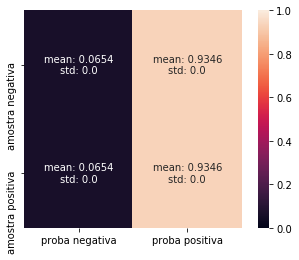

Margem de probabilidade para todos os canais do CHB 12
Para o grupo de canais all


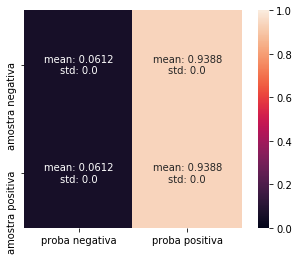

Para o grupo de canais 6ch


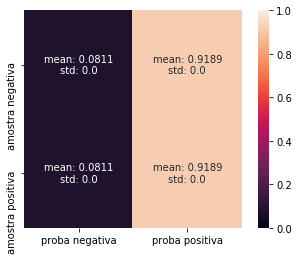

Para o grupo de canais 8ch


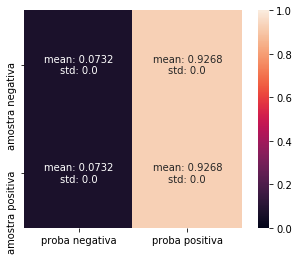

Margem de probabilidade para todos os canais do CHB 13
Para o grupo de canais all


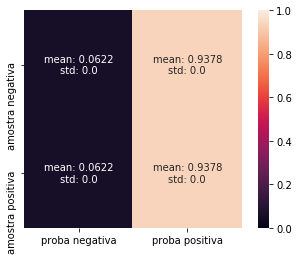

Para o grupo de canais 6ch


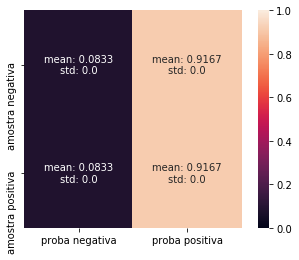

Para o grupo de canais 8ch


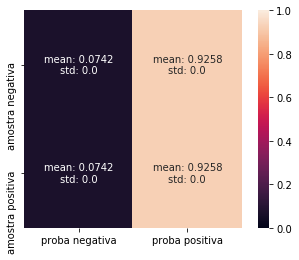

Margem de probabilidade para todos os canais do CHB 14
Para o grupo de canais all


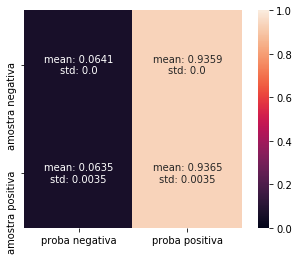

Para o grupo de canais 6ch


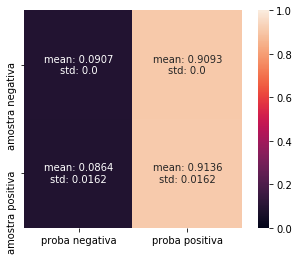

Para o grupo de canais 8ch


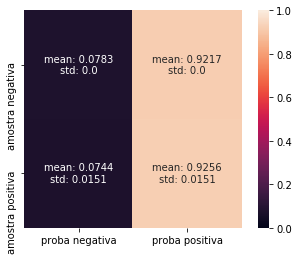

Margem de probabilidade para todos os canais do CHB 15
Para o grupo de canais all


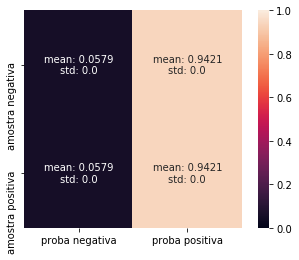

Para o grupo de canais 6ch


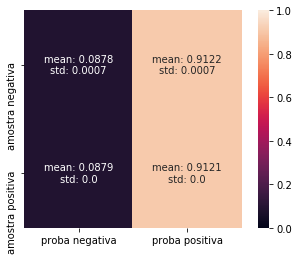

Para o grupo de canais 8ch


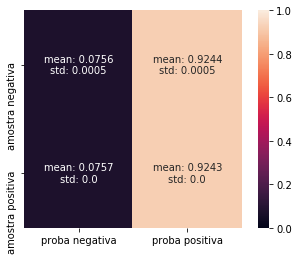

Margem de probabilidade para todos os canais do CHB 16
Para o grupo de canais all


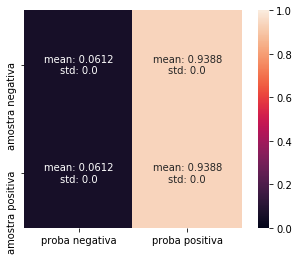

Para o grupo de canais 6ch


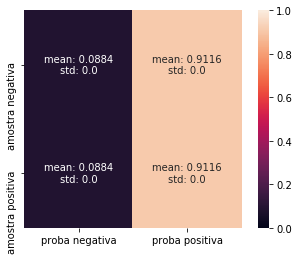

Para o grupo de canais 8ch


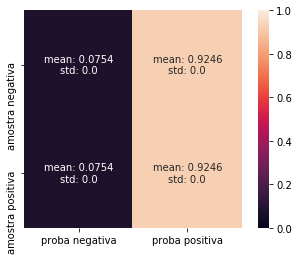

Margem de probabilidade para todos os canais do CHB 17
Para o grupo de canais all


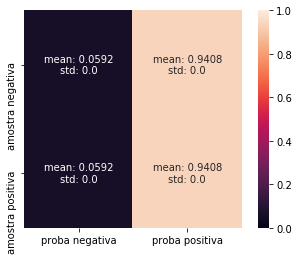

Para o grupo de canais 6ch


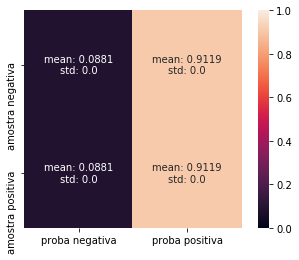

Para o grupo de canais 8ch


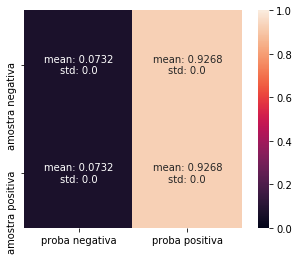

Margem de probabilidade para todos os canais do CHB 18
Para o grupo de canais all


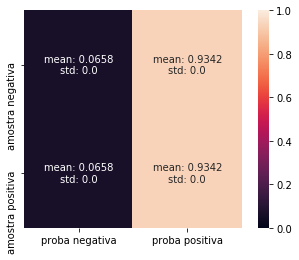

Para o grupo de canais 6ch


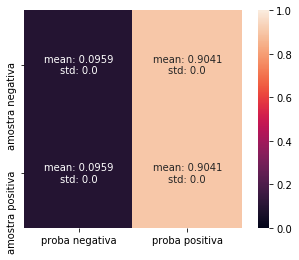

Para o grupo de canais 8ch


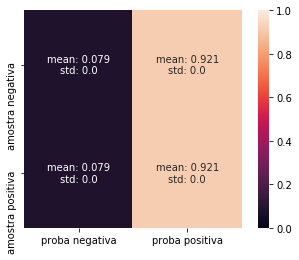

Margem de probabilidade para todos os canais do CHB 19
Para o grupo de canais all


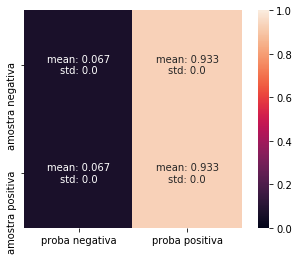

Para o grupo de canais 6ch


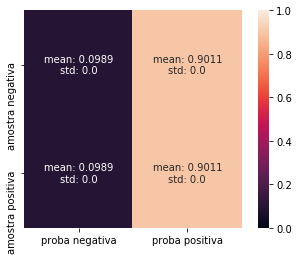

Para o grupo de canais 8ch


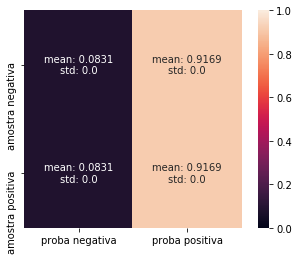

Margem de probabilidade para todos os canais do CHB 21
Para o grupo de canais all


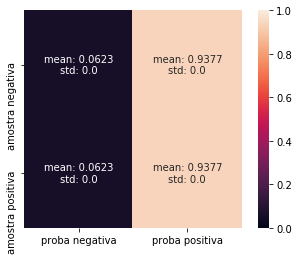

Para o grupo de canais 6ch


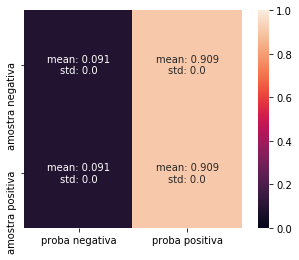

Para o grupo de canais 8ch


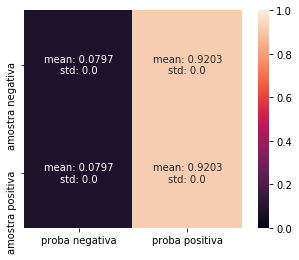

Margem de probabilidade para todos os canais do CHB 22
Para o grupo de canais all


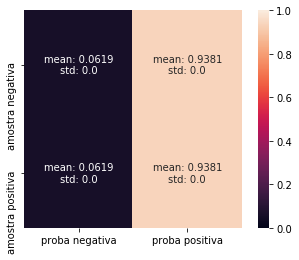

Para o grupo de canais 6ch


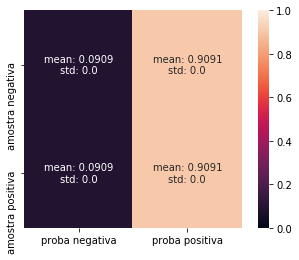

Para o grupo de canais 8ch


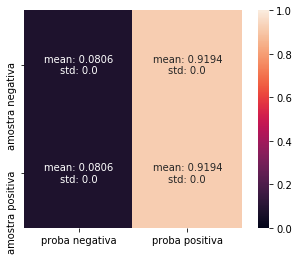

Margem de probabilidade para todos os canais do CHB 23
Para o grupo de canais all


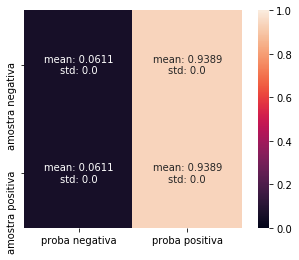

Para o grupo de canais 6ch


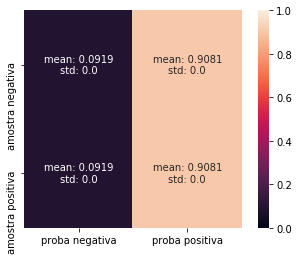

Para o grupo de canais 8ch


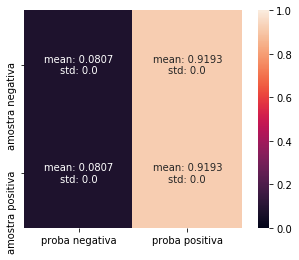

Margem de probabilidade para todos os canais do CHB 24
Para o grupo de canais all


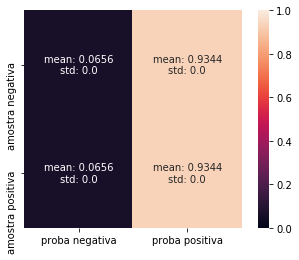

Para o grupo de canais 6ch


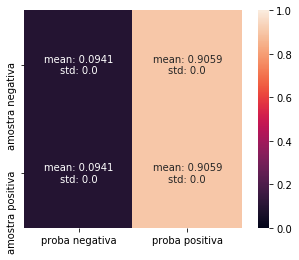

Para o grupo de canais 8ch


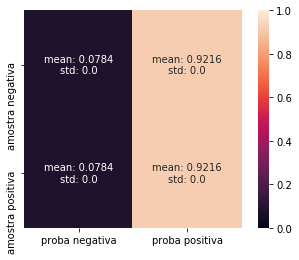

In [7]:
for chb in file_range:
    print(f'Margem de probabilidade para todos os canais do CHB {chb}')

    for channel in ['all', '6ch', '8ch']:
        print(f'Para o grupo de canais {channel}')

        mean_arr, std_arr = proba_dict[chb][channel].mean(axis=1), proba_dict[chb][channel].std(axis=1)
        annotations = \
            np.array(
                [f'mean: {round(mean, 4)}\nstd: {round(std, 4)}' for mean, std in zip(mean_arr.flatten(), std_arr.flatten())]
            ).reshape((2, 2))

        heatmap(
            data=mean_arr,
            annot=annotations,
            fmt='',
            cbar=True,
            vmin=0,
            vmax=1,
            square=True,
            xticklabels=['proba negativa', 'proba positiva'],
            yticklabels=['amostra negativa', 'amostra positiva']
        )

        plt.show()